<a href="https://colab.research.google.com/github/nadavru/iLearn/blob/iLearnML/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()

<Figure size 432x288 with 0 Axes>

In [2]:
from abc import ABCMeta, abstractmethod
from IPython.display import IFrame

class Trainer:
    def __init__(self, grid_x, grid_y, lr=0.5, epochs=50): 
        self.lr=lr
        self.x_cur = 2*grid_x*np.random.random_sample()-grid_x
        self.y_cur = 2*grid_y*np.random.random_sample()-grid_y
        self.epochs=epochs

        x = np.linspace(-grid_x, grid_x, 1000)
        y = np.linspace(-grid_y, grid_y, 1000)
        self.X, self.Y = np.meshgrid(x, y)

    def __call__(self): 
        return self.X, self.Y, np.where(True, self.calc(self.X, self.Y), 0)
    
    def train(self): 
        self.Xs = [self.x_cur]
        self.Ys = [self.y_cur]
        self.Zs = [self.calc(self.x_cur, self.y_cur)]

        for _ in range(self.epochs):
            d = self.derive(self.x_cur, self.y_cur)
            #print(d)
            self.x_cur -= self.lr*d[0]
            self.y_cur -= self.lr*d[1]

            self.Xs.append(self.x_cur)
            self.Ys.append(self.y_cur)
            self.Zs.append(self.calc(self.x_cur, self.y_cur))
        return self.Xs, self.Ys, self.Zs

    @abstractmethod
    def display(self): 
      pass
    
    @abstractmethod
    def calc(self, x, y): 
      pass

    @abstractmethod
    def derive(self, x, y): 
      pass

In [3]:
from math import exp

e = exp(1)

class Gaussian_helper: 
    def __init__(self, a, px, py, c=1): 
        self.a=a
        self.px=px
        self.py=py
        self.c=c

    def calc(self, x, y): 
        return -self.a*e**(-((x-self.px)**2+(y-self.py)**2)/(2*self.c**2))

    def derive(self, x, y): 
        tmp = (self.a/self.c**2)*e**(-((x-self.px)**2+(y-self.py)**2)/(2*self.c**2))
        return (tmp*(x-self.px), tmp*(y-self.py))

class Gaussian(Trainer):

    def __init__(self, apc:list, grid_x, grid_y, lr=0.5, epochs=50): 
        super().__init__(grid_x, grid_y, lr, epochs)
        self.g_list = [Gaussian_helper(*i) for i in apc]

        url = "https://htmlpreview.github.io/?https://github.com/nadavru/iLearn/blob/iLearnML/ilearnml_graph_viewer.html#"
        self.disp_url = url+f"xmax={grid_x}&xmin=-{grid_x}&ymax={grid_y}&ymin=-{grid_y}&"

        self.f_str = ""
        for a, px, py, c in apc:
            s_x = "-"+(str)(px) if px>0 else "+"+(str)(-px)
            s_y = "-"+(str)(py) if py>0 else "+"+(str)(-py)
            self.f_str += f"-{a}*e^(-((x{s_x})^2+(y{s_y})^2)/(2*{c}^2))"
        
    def calc(self, x, y): 
        return sum([G.calc(x, y) for G in self.g_list])

    def derive(self, x, y): 
        d_list = [G.derive(x, y) for G in self.g_list]
        return [sum(i) for i in zip(*d_list)]
    
    def display(self): 
        points_str = ""
        for i in range(len(self.Xs)):
          points_str+=(str)(self.Xs[i])+","+(str)(self.Ys[i])+","+(str)(self.Zs[i])+"|"
        points_str=points_str[:-1]

        src=self.disp_url+f"func={self.f_str}&points={points_str}"
        return src

In [4]:
#from mpmath import sech

class SVM(Trainer):

  def __init__(self, group_size, p0, p1, grid_x=50, grid_y=50, lr=0.5, epochs=10): 
        super().__init__(grid_x, grid_y, lr, epochs)
        (x0, y0, var0) = p0
        (x1, y1, var1) = p1
        self.group_size = group_size
        group0 = np.array(list(zip(list(np.random.normal(x0, var0, group_size)), list(np.random.normal(y0, var0, group_size)),[-1]*group_size)))
        group1 = np.array(list(zip(list(np.random.normal(x1, var1, group_size)), list(np.random.normal(y1, var0, group_size)),[1]*group_size)))

        self.data = np.concatenate((group0, group1))

        url = "https://htmlpreview.github.io/?https://github.com/nadavru/iLearn/blob/iLearnML/scatter.html#"
        #grid = 30
        self.disp_url = url+f"xmax={grid_x}&xmin=-{grid_x}&ymax={grid_y}&ymin=-{grid_y}&"
        
        url2 = "https://htmlpreview.github.io/?https://github.com/nadavru/iLearn/blob/iLearnML/ilearnml_graph_viewer.html#"
        self.disp_url2 = url2+f"xmax={grid_x}&xmin=-{grid_x}&ymax={grid_y}&ymin=-{grid_y}&"

        #self.X, self.Y = np.concatenate((self.group0[:,0],self.group1[:,0])), np.concatenate((self.group0[:,1],self.group1[:,1]))

  def calc(self, x, y): 
    '''act0 = np.tanh(x*self.group0[:,0]+y*self.group0[:,1])+1
    act1 = 1-np.tanh(x*self.group1[:,0]+y*self.group1[:,1])

    loss = (np.sum(act0)+np.sum(act1))/(2*self.group_size)'''
    pred = np.sign(np.tanh(x*self.data[:,0]+y*self.data[:,1]))
    #print(pred, self.data[:,2])
    acc = np.sum(np.equal(pred, self.data[:,2]))/(2*self.group_size)
    #print(acc)
    #loss = np.mean(1-np.tanh(self.data[:,2]*(x*self.data[:,0]+y*self.data[:,1])))
    '''self.scores = (x*self.data[:,0]+y*self.data[:,1])
    self.keep = np.exp(-self.data[:,2]*self.scores)/(1+np.exp(-self.data[:,2]*self.scores))
    loss = np.mean(self.keep)'''
    loss = np.mean(-self.data[:,2]*(x*self.data[:,0]+y*self.data[:,1]))
    return loss
  
  def pred(self):
    pred_y = np.sign(np.tanh(self.x_cur*self.data[:,0]+self.y_cur*self.data[:,1]))
    acc = np.sum(np.equal(pred_y, self.data[:,2]))/(2*self.group_size)
    return acc
  
  def derive(self, x, y): 
    '''der0 = 1/(2*self.group_size*np.cosh(x*self.group0[:,0]+y*self.group0[:,1])**2)
    der1 = -1/(2*self.group_size*np.cosh(x*self.group1[:,0]+y*self.group1[:,1])**2)
    dx = np.sum(self.group0[:,0]*der0) + np.sum(self.group1[:,0]*der1)
    dy = np.sum(self.group0[:,1]*der0) + np.sum(self.group1[:,1]*der1)'''
    
    '''der = -1/np.cosh(self.data[:,2]*(x*self.data[:,0]+y*self.data[:,1]))**2
    dx = np.mean(self.data[:,2]*self.data[:,0]*der)
    dy = np.mean(self.data[:,2]*self.data[:,1]*der)'''
    
    '''der = -self.keep*(1-self.keep)
    dx = np.mean(self.data[:,2]*self.data[:,0]*der)
    dy = np.mean(self.data[:,2]*self.data[:,1]*der)'''

    dx = np.mean(-self.data[:,2]*self.data[:,0])
    dy = np.mean(-self.data[:,2]*self.data[:,1])

    return [dx, dy]

  def display(self): 
    points_str = ""
    x = 30
    for i in range(len(self.Xs)):
      points_str+=(str)(-x)+","+(str)(x*self.Xs[i]/self.Ys[i])+","+(str)(0)+"|"+(str)(x)+","+(str)(-x*self.Xs[i]/self.Ys[i])+","+(str)(0)+"|"
    points_str=points_str[:-1]

    points_red = ""
    for (x,y) in self.data[:self.group_size,:2]:
      points_red += f"{x},{y},0"+"|"
    points_red=points_red[:-1]
    
    points_blue = ""
    for (x,y) in self.data[self.group_size:,:2]:
      points_blue += f"{x},{y},0"+"|"
    points_blue=points_blue[:-1]

    src=self.disp_url+f"points_red={points_red}&points_blue={points_blue}&vec={points_str}"
    return src
  
  def display2(self): 
    points_str = ""
    for i in range(len(self.Xs)):
      points_str+=(str)(self.Xs[i])+","+(str)(self.Ys[i])+","+(str)(self.Zs[i])+"|"
    points_str=points_str[:-1]

    x_sum = np.mean(-self.data[:,2]*self.data[:,0])
    y_sum = np.mean(-self.data[:,2]*self.data[:,1])
    
    f_str = f"{x_sum}*x+{y_sum}*y".replace("+-","-")

    src=self.disp_url2+f"func={f_str}&points={points_str}"
    return src

    

In [18]:
class Rosenbrock(Trainer):

    def __init__(self, a=1, b=100, grid_x=3, grid_y=3, lr=0.0001, epochs=50): 
        super().__init__(grid_x, grid_y, lr, epochs)

        url = "https://htmlpreview.github.io/?https://github.com/nadavru/iLearn/blob/iLearnML/ilearnml_graph_viewer.html#"
        self.disp_url = url+f"xmax={grid_x}&xmin=-{grid_x}&ymax={grid_y}&ymin=-{grid_y}&"

        self.a, self.b = a, b
        self.f_str = f"({a}-x)^2+{b}*(y-x^2)^2"
        
        
    def calc(self, x, y): 
        return (self.a-x)**2+self.b*(y-x**2)**2

    def derive(self, x, y): 
        dx = 2*x*(-2*self.b*(y-x**2)-1)
        dy = 2*self.b*(y-x**2)
        return [dx, dy]
    
    def display(self): 
        points_str = ""
        for i in range(len(self.Xs)):
          points_str+=(str)(self.Xs[i])+","+(str)(self.Ys[i])+","+(str)(self.Zs[i])+"|"
        points_str=points_str[:-1]

        src=self.disp_url+f"func={self.f_str}&points={points_str}"
        return src


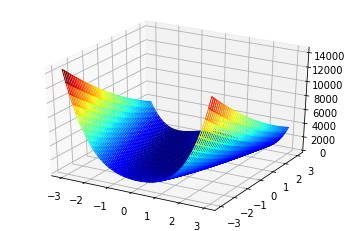

In [19]:
from matplotlib import cm

R = Rosenbrock()

X, Y, Z = R()
ax = plt.axes(projection='3d')
norm = plt.Normalize(Z.min(), Z.max())
colors = cm.jet(norm(Z))
surf = ax.plot_surface(X, Y, Z, facecolors=colors, shade=False)
surf.set_facecolor((0,0,0,0))

In [20]:
Xs, Ys, Zs = R.train()

In [22]:
src = R.display()
#print(src)i

IFrame(src=src, width=700, height=600)

In [36]:
import math
pi = math.pi
class Rastrigin(Trainer):

    def __init__(self, A=10, grid_x=6, grid_y=6, lr=0.0001, epochs=50): 
        super().__init__(grid_x, grid_y, lr, epochs)

        url = "https://htmlpreview.github.io/?https://github.com/nadavru/iLearn/blob/iLearnML/ilearnml_graph_viewer.html#"
        self.disp_url = url+f"xmax={grid_x}&xmin=-{grid_x}&ymax={grid_y}&ymin=-{grid_y}&"

        self.A = A
        self.f_str = f"{2*A}+x^2-{A}*cos({2*pi}*x)+y^2-{A}*cos({2*pi}*y)"
        
        
    def calc(self, x, y): 
        return 2*self.A+x**2-self.A*math.cos(2*pi*x)+y**2-self.A*math.cos(2*pi*y)

    def derive(self, x, y): 
        dx = 2*(pi*self.A*math.sin(2*pi*x)+x)
        dy = 2*(pi*self.A*math.sin(2*pi*y)+y)
        return [dx, dy]
    
    def display(self): 
        points_str = ""
        for i in range(len(self.Xs)):
          points_str+=(str)(self.Xs[i])+","+(str)(self.Ys[i])+","+(str)(self.Zs[i])+"|"
        points_str=points_str[:-1]

        src=self.disp_url+f"func={self.f_str}&points={points_str}"
        return src

In [37]:
from matplotlib import cm

Ra = Rastrigin()

'''X, Y, Z = Ra()
ax = plt.axes(projection='3d')
norm = plt.Normalize(Z.min(), Z.max())
colors = cm.jet(norm(Z))
surf = ax.plot_surface(X, Y, Z, facecolors=colors, shade=False)
surf.set_facecolor((0,0,0,0))'''

TypeError: ignored

In [38]:
Xs, Ys, Zs = Ra.train()

In [39]:
src = Ra.display()
#print(src)

IFrame(src=src, width=700, height=600)

https://htmlpreview.github.io/?https://github.com/nadavru/iLearn/blob/iLearnML/ilearnml_graph_viewer.html#xmax=6&xmin=-6&ymax=6&ymin=-6&func=20+x^2-10*cos(6.283185307179586*x)+y^2-10*cos(6.283185307179586*y)&points=-5.587973125404991,0.13108977854509085,52.95806322944766|-5.590154397374923,0.12645397213583517,52.69771862017321|-5.592408210441911,0.12194539606892874,52.44566922246483|-5.594736311609068,0.11756420774028153,52.201407521164356|-5.597140423615479,0.11331015807478928,51.96438545280283|-5.5996222368213635,0.10918262594013434,51.73402165970684|-5.602183400374204,0.10518065248661668,51.5097083675243|-5.604825512633997,0.10130297495772009,51.29081785060568|-5.607550110841343,0.09754805959137165,51.07670847062644|-5.610358660019051,0.0939141333039508,50.866730291527524|-5.61325254110633,0.0903992139164362,50.66023028816659|-5.616233038334596,0.08700113874353763,50.4565571770679|-5.6193013258656,0.08371759142158162,50.25506590546193|-5.622458453725994,0.08054612689900766,50.055121

In [44]:
class Himmelblau(Trainer):

    def __init__(self, grid_x=6, grid_y=6, lr=0.001, epochs=50): 
        super().__init__(grid_x, grid_y, lr, epochs)

        url = "https://htmlpreview.github.io/?https://github.com/nadavru/iLearn/blob/iLearnML/ilearnml_graph_viewer.html#"
        self.disp_url = url+f"xmax={grid_x}&xmin=-{grid_x}&ymax={grid_y}&ymin=-{grid_y}&"

        self.f_str = f"(x^2+y-11)^2+(x+y^2-7)^2"
        
        
    def calc(self, x, y): 
        return (x**2+y-11)**2+(x+y**2-7)**2

    def derive(self, x, y): 
        dx = 2*(2*x*(x**2+y-11)+x+y**2-7)
        dy = 2*(2*y*(x+y**2-7)+x**2+y-11)
        return [dx, dy]
    
    def display(self): 
        points_str = ""
        for i in range(len(self.Xs)):
          points_str+=(str)(self.Xs[i])+","+(str)(self.Ys[i])+","+(str)(self.Zs[i])+"|"
        points_str=points_str[:-1]

        src=self.disp_url+f"func={self.f_str}&points={points_str}"
        return src

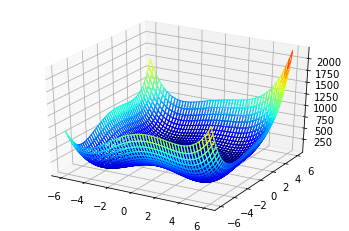

In [45]:
from matplotlib import cm

H = Himmelblau()

X, Y, Z = H()
ax = plt.axes(projection='3d')
norm = plt.Normalize(Z.min(), Z.max())
colors = cm.jet(norm(Z))
surf = ax.plot_surface(X, Y, Z, facecolors=colors, shade=False)
surf.set_facecolor((0,0,0,0))

In [46]:
Xs, Ys, Zs = H.train()

In [47]:
src = H.display()
#print(src)

IFrame(src=src, width=700, height=600)

In [ ]:
T = SVM(50, (-5,-5,5), (5,5,5), lr=0.5, epochs=30)
print(f"accuracy before training: {100*T.pred()}%")
Xs, Ys, Zs = T.train()
'''print(Xs)
print(Ys)
print(Zs)'''
print(f"accuracy after training: {100*T.pred()}%")

accuracy before training: 60.0%
accuracy after training: 88.0%


In [ ]:
src = T.display()
print(src)

IFrame(src=src, width=700, height=600)

https://htmlpreview.github.io/?https://github.com/nadavru/iLearn/blob/iLearnML/scatter.html#xmax=50&xmin=-50&ymax=50&ymin=-50&points_red=-14.520615558056747,-5.519106781098278,0|-8.163450932605175,-5.857787676246948,0|-10.26015677048731,-8.256387302341349,0|-7.879648820974845,-9.15475975893941,0|-15.027807230183788,-8.344580983188058,0|6.279131225442303,1.7016687373341508,0|-6.279846488076304,-4.309063717028256,0|-8.010977522011366,-13.84359878481826,0|-5.5836273673797425,-11.62919402399633,0|-9.648947804169541,-2.3414621029101563,0|0.3172217200670904,-6.619565553856243,0|-4.9871939357397235,-10.650994882027662,0|-4.001019087372355,-3.7168991713245934,0|-11.709945320549288,-4.226851475161576,0|-4.0275669835741885,-12.19837658825043,0|-8.932090109067076,-13.591092135941615,0|1.583977459995216,-5.681631769131793,0|-7.939698187337276,-1.374999313624631,0|-8.321870119784077,-6.7726463201236164,0|6.291120757379067,0.11830106921377226,0|-3.597729612263266,-4.55694783394977,0|-1.2839313231154

In [ ]:
src = T.display2()
#print(src)

IFrame(src=src, width=700, height=600)

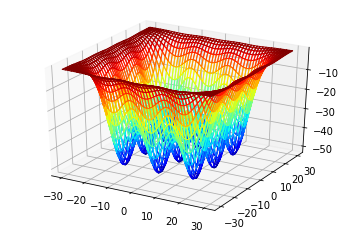

In [ ]:
from matplotlib import cm

sizes = []
for ix in [-15,0,15]:
  for iy in [-15,0,15]:
    sizes.append((50,ix,iy,5))

grid_x = 30
grid_y = 30

G = Gaussian(sizes, grid_x, grid_y)

X, Y, Z = G()
ax = plt.axes(projection='3d')
norm = plt.Normalize(Z.min(), Z.max())
colors = cm.jet(norm(Z))
surf = ax.plot_surface(X, Y, Z, facecolors=colors, shade=False)
surf.set_facecolor((0,0,0,0))

In [ ]:
Xs, Ys, Zs = G.train()

In [ ]:
src = G.display()
#print(src)i

IFrame(src=src, width=700, height=600)